In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar

from json_data_getter import get_all_json

# Data preparation

## Loading

In [2]:
# gets all the json files toghether, may take a minute
_, _, documents = get_all_json()
df = pd.DataFrame.from_dict(documents)

100% (109 of 109) |########################################| Elapsed Time: 0:00:33 Time: 0:00:33


## Cleaning

In [3]:
# keep NaN for float columns, empty strings for string columns
with progressbar.ProgressBar(max_value=len(df.columns)) as bar:        
    for i,col in enumerate(df):
        # get dtype for column
        dt = df[col].dtype
        # check if it is a number
        if dt == int or dt == float:
            pass
        else:
            df[col].fillna("", inplace=True)
        bar.update(i)

# set dates to datetime type
df['publicationDate'] = pd.to_datetime(
    df['publicationDate'], format='%Y-%m-%dT%H:%M:%SZ')

100% (27 of 27) |##########################################| Elapsed Time: 0:00:01 Time: 0:00:01


In [4]:
df.columns.values

array(['alternativeExcerpt', 'alternativeTitle', 'articleURL',
       'backgrounds', 'contributors', 'durationSec', 'excerpt', 'genres',
       'id', 'imageURL', 'isOnline', 'mediaType', 'mediaURL', 'program',
       'publicationChannelNames', 'publicationDate', 'source',
       'thematicCorporations', 'thematicGeographicals', 'thematicPersons',
       'thematicThemes', 'title', 'variantIds', 'visualCorporations',
       'visualGeographicals', 'visualPersons', 'visualThemes'], dtype=object)

## distribution in time

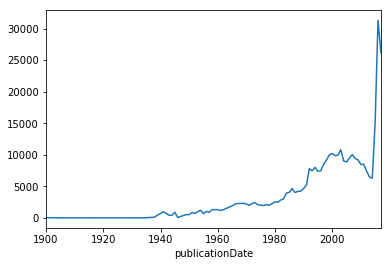

In [5]:
doc_per_year = df.groupby(df.publicationDate.map(lambda x: x.year)).size()
doc_per_year.plot()
plt.show()

## Programs lifespan

In [6]:
def get_program_lifespan(df):
    program_groups = df.groupby(df.program)
    df_lifespan = program_groups.publicationDate.agg(['min', 'max', 'size'])
    df_lifespan['lifespan_days'] = (
        df_lifespan['max'] - df_lifespan['min']).astype('timedelta64[D]')
    return df_lifespan

In [7]:
get_program_lifespan(df).sort_values('lifespan_days', ascending=False).head()

min                 max   size  \
program                                                                 
                       1900-01-01 00:00:00 2017-11-15 00:00:00  20458   
TJ midi                1900-01-01 19:00:00 2011-12-04 11:45:00    204   
Marabout de ficelle    1900-01-01 00:00:00 1998-05-20 00:00:00    148   
Mémoires de la musique 1922-06-05 00:00:00 2004-01-23 00:00:00   2086   
Archives               1939-11-30 02:00:00 2017-10-03 13:10:37    120   

                        lifespan_days  
program                                
                              43052.0  
TJ midi                       40878.0  
Marabout de ficelle           35933.0  
Mémoires de la musique        29817.0  
Archives                      28432.0

The first row is the group of unnamed programs. Some duration seem a bit too long, maybe there are errors in the dates. Let's take TJ midi and check the distribution of transmissions by year.

In [8]:
def plot_program_lifespan(program, df):
    program_groups = df.groupby(df.program)
    group = program_groups.get_group(program)
    date_distribution = group.groupby(
        group.publicationDate.map(lambda x: (x.year))).size()
    plt.bar(date_distribution.index, date_distribution.values)
    plt.show()

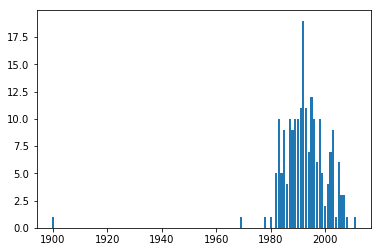

In [9]:
plot_program_lifespan('TJ midi', df)

There are some obvious outliers, let's remove them.

### Date outliers removal

In [10]:
# remove date outliers
def remove_date_outliers(df):
    CONSTANT_STD = 2
    df_without_date_outliers = df.copy()

    df['publicationDateYear'] = df.publicationDate.map(lambda x: x.year)

    mean_std_year_per_program = df.groupby(df.program).publicationDateYear.agg(
        ["mean", 'std'])

    temp_df = pd.merge(
        df,
        mean_std_year_per_program,
        how='left',
        left_on=['program'],
        right_index=True)

    df_without_date_outliers.loc[
        (np.abs(temp_df.publicationDateYear - temp_df['mean']) >
         CONSTANT_STD * temp_df['std']), 'publicationDate'] = pd.NaT

    return df_without_date_outliers

In [11]:
df_without_date_outliers = remove_date_outliers(df)
get_program_lifespan(df_without_date_outliers).sort_values(
    'size', ascending=False).head()

min                 max   size  lifespan_days
program                                                                       
Journal du matin 1989-01-07 00:00:00 2017-08-28 00:00:00  21767        10460.0
                 1921-11-23 00:00:00 2017-11-15 00:00:00  20458        35056.0
Forum            2004-12-26 23:00:00 2017-11-16 00:00:00  10633         4707.0
Télé journal     1982-01-01 00:00:00 1996-09-30 23:00:00  10520         5386.0
Journal de midi  1982-01-09 00:00:00 2017-08-01 00:00:00   8440        12988.0

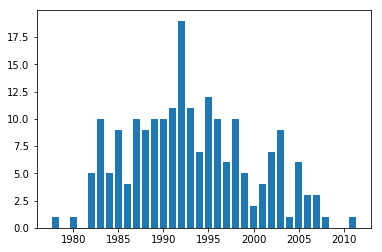

In [12]:
plot_program_lifespan('TJ midi', df_without_date_outliers)

# Gender (Sina)

# Location (Mohammed)

# Factors for program lifespan (Leo)

In [58]:
counters_program_period = df_without_date_outliers.groupby([
    df_without_date_outliers.program,
    df_without_date_outliers.publicationDate.apply(lambda x: x.year)
])[
    'genres', 'publicationChannelNames', 'thematicCorporations','thematicGeographicals',
    'thematicThemes', 'visualCorporations', 'visualGeographicals', 'visualPersons',
    'visualThemes'
].agg(agg_counter)

In [59]:
counters_program_period.columns

Index(['genres', 'publicationChannelNames', 'thematicCorporations',
       'thematicGeographicals', 'thematicThemes', 'visualCorporations',
       'visualGeographicals', 'visualPersons', 'visualThemes'],
      dtype='object')

In [62]:
counters_program_period.head(10)

genres  \
program publicationDate                                                      
        1921.0                                                [(Récit, 2)]   
        1922.0                           [(Commentaire, 2), (Variétés, 2)]   
        1923.0               [(Documentaire, 2), (Théâtre, 2), (Récit, 1)]   
        1924.0                                                  [(INT, 2)]   
        1925.0                       [(Parlé divers, 2), (Commentaire, 2)]   
        1927.0                                          [(Commentaire, 6)]   
        1928.0                                          [(Déclaration, 1)]   
        1929.0           [(Commentaire, 4), (Déclaration, 2), (Intervie...   
        1930.0             [(Déclaration, 10), (Interview, 4), (Récit, 2)]   
        1931.0           [(Déclaration, 2), (Commentaire, 2), (Variétés...   

                                        publicationChannelNames  \
program publicationDate                                           
        1921.0                                               []   
        1922.0                                               []   
        1923.0                               [(La Première, 2)]   
        1924.0                                               []   
        1925.0                                               []   
        1927.0                                               []   
        1928.0                                               []   
        1929.0                                               []   
        1930.0           [(La Première, 6), (Radio Sottens, 2)]   
        1931.0                             [(Radio Sottens, 2)]   

                        thematicCorporations  \
program publicationDate                        
        1921.0                            []   
        1922.0                            []   
        1923.0                            []   
        1924.0                            []   
        1925.0                            []   
        1927.0                            []   
        1928.0                            []   
        1929.0                            []   
        1930.0                            []   
        1931.0                            []   

                                                     thematicGeographicals  \
program publicationDate                                                      
        1921.0                                                          []   
        1922.0                                                          []   
        1923.0                                                          []   
        1924.0                                               [(France, 2)]   
        1925.0                                                          []   
        1927.0                                                          []   
        1928.0                                               [(France, 1)]   
        1929.0           [(Grande-Bretagne, 2), (France, 2), (Genève (v...   
        1930.0           [(France, 8), (Anvers, 4), (Belgique, 4), (Rus...   
        1931.0                                    [(France, 4), (URSS, 2)]   

                                                            thematicThemes  \
program publicationDate                                                      
        1921.0                                             [(jeunesse, 1)]   
        1922.0                            [(voix, 2), (voix (musique), 2)]   
        1923.0                                                          []   
        1924.0                                          [(littérature, 2)]   
        1925.0                                    [(cinéma, 2), (voix, 2)]   
        1927.0                                                 [(voix, 6)]   
        1928.0             [(désarmement, 1), (réunion internationale, 1)]   
        1929.0           [(voix, 4), (relations internationales, 2), (a...   
        1930.0           [(guerr

In [66]:
counters_program_period.loc[counters_program_period.index.get_level_values('publicationDate') == 1955].sum()

genres                     [(INT, 123), (Interview, 122), (Déclaration, 7...
publicationChannelNames    [(La Première, 163), (Radio Sottens, 59), (Rad...
thematicCorporations                                                      []
thematicGeographicals      [(France, 135), (Suisse, 42), (Paris, 33), (Et...
thematicThemes             [(art dramatique, 47), (littérature, 45), (écr...
visualCorporations                                                        []
visualGeographicals        [(GENEVE-VILLE, 13), (VAUD, 4), (COINTRIN, 4),...
visualPersons              [(FAURE, EDGAR, 10), (EISENHOWER, DWIGHT, 9), ...
visualThemes               [(ANNÉES 1950, 21), (RÉUNION INTERNATIONALE, 1...
dtype: object

In [76]:
def get_themes(fr, to, theme, program=1):
    rows_selection = ((counters_program_period.index.get_level_values('publicationDate') >= fr) &
    (counters_program_period.index.get_level_values('publicationDate') <= to) &
    (counters_program_period.index.get_level_values('program') == program))
    return counters_program_period.loc[rows_selection][theme].sum()

In [77]:
get_themes(1955,1955, '', 'thematicThemes')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Themes in periods

In [15]:
from collections import Counter
import datetime

def get_themes(df, theme_type, program='', from_ = '', to='', n=10):
    
    temp_df = df
    
    if program:
        temp_df = temp_df.loc[temp_df.program == program]
    if from_:
        temp_df = temp_df.loc[temp_df.publicationDate >= from_]
    if to:
        temp_df = temp_df.loc[temp_df.publicationDate <= to]

    flat_list = [item for sublist in temp_df[theme_type].values for item in sublist]
    #return' '.join(flat_list)
    return Counter(flat_list).most_common(n)

def theme_per_year(theme_type, program='',n_top = 3):
    columns_name = ['top' + str(i+1) for i in range(n_top)]
    themes_per_year = pd.DataFrame(columns=columns_name)
    for i in range(1921, 2018):
        temp_themes = get_themes(
            df_without_date_outliers,
            theme_type,
            program,
            from_=datetime.date(i, 1, 1),
            to=datetime.date(i+1,1,1),
            n=n_top)

        top_themes = [''] * n_top
        for j in range(len(temp_themes)):
            top_themes[j] = (temp_themes[j][0])

        themes_per_year.loc[i] = top_themes
    return themes_per_year

possible_themes = [
    'genres', 'publicationChannelNames', 'thematicCorporations',
    'thematicGeographicals', 'thematicPersons', 'thematicThemes',
    'visualCorporations', 'visualGeographicals', 'visualPersons',
    'visualThemes'
]

possible_programs = df_without_date_outliers.program.unique()

In [75]:
thematicThemes_per_year = theme_per_year('thematicThemes')
visualThemes_per_year = theme_per_year('visualThemes')
thematicPersons_per_year = theme_per_year('thematicPersons')
thematicGeographicals_per_year = theme_per_year('thematicGeographicals')
thematicCorporations_per_year = theme_per_year('thematicCorporations')

In [148]:
thematicPersons_per_year

top0                      top1  \
1921          Einstein, Albert        Valentino, Rudolph   
1922          Einstein, Albert        Valentino, Rudolph   
1923           Dreyfus, Alfred              Jeanne d'Arc   
1924           Dreyfus, Alfred              Jeanne d'Arc   
1925           Stein, Gertrude                             
1926          Carnegie, Andrew       Conan Doyle, Arthur   
1927          Carnegie, Andrew       Conan Doyle, Arthur   
1928                       SDN          Briand, Aristide   
1929                       SDN          Briand, Aristide   
1930         Koechlin, Charles                   Expo 64   
1931                       SDN          Indy, Vincent d'   
1932                       SDN       Rappard, William E.   
1933         Mussolini, Benito                   Expo 64   
1934                       SDN        Hailé Sélassié 1er   
1935                       SDN             Benes, Edvard   
1936           Front populaire                Blum, Léon   
1937             Knie (cirque)                       RSR   
1938                       RSR            Radio-Lausanne   
1939  Ramuz, Charles Ferdinand                       RSR   
1940  Ramuz, Charles Ferdinand            Radio-Lausanne   
1941            Radio-Lausanne  Ramuz, Charles Ferdinand   
1942                      CICR            Doret, Gustave   
1943                       RSR              Radio-Genève   
1944                       RSR              Radio-Genève   
1945                       ONU        Gaulle, Charles de   
1946                       ONU                       SDN   
1947                                                       
1948                       RSR            Radio-Lausanne   
1949                       ONU                    UNESCO   
1950              Radio-Genève                       ONU   
...                        ...                       ...   
1988           Béjart, Maurice               Piaf, Edith   
1989             CHARLES, JEAN        GOLOVTCHINER, LOVA   
1990        GOLOVTCHINER, LOVA             RIESEN, RAOUL   
1991        GOLOVTCHINER, LOVA  Mozart, Wolfgang Amadeus   
1992                       EEE                       ONU   
1993                       OLP                       RSR   
1994                       OTS   Ordre du Temple solaire   
1995                       OTS                       CIO   
1996                       RSR              Radio-Genève   
1997                       RSR              Radio-Genève   
1998    Delamuraz, Jean-Pascal         Couchepin, Pascal   
1999                       RSR   Fête des vignerons 1999   
2000                       RSR                  Espace 2   
2001                       RSR                  Swissair   
2002                   Expo.02                       RSR   
2003                        G8             America's Cup   
2004        Blocher, Christoph           Rimbaud, Arthur   
2005                     Paléo                Astonvilla   
2006                 Couleur 3                     Paléo   
2007                 Couleur 3        Blocher, Christoph   
2008                       UDC                       RSR   
2009                       UBS             Obama, Barack   
2010         Gainsbourg, Serge           Conseil fédéral   
2011       Kadhafi, Muammar al           Conseil fédéral   
2012             Chedid, Louis          Chedid, Matthieu   
2013             Chedid, Louis          Chedid, Matthieu   
2014     Groupe Etat islamique            Etat islamique   
2015     Groupe Etat islamique            Etat islamique   
2016     Groupe Etat islamique             Trump, Donald   
2017             Trump, Donald          Macron, Emmanuel   

                                top2  
1921                Kipling, Rudyard  
1922                                  
1923                     Zola, Emile  
1924                     Zola, Emile  
1925                                  
1926              Lindbergh, Charles  
1927              Lindbergh, Cha

In [111]:
thematicThemes_per_year_journaldumatin = theme_per_year('thematicGeographicals', program='Journal du matin', n_top = 10)

In [112]:
thematicThemes_per_year_journaldumatin[68:]

top1                top2                top3                  top4  \
1989  Suisse              Romont             Pologne     Fribourg (canton)   
1990  Suisse   Fribourg (canton)  Neuchâtel (canton)                Romont   
1991  Suisse                Irak          Etats-Unis                Israël   
1992  Suisse              Europe              France           Yougoslavie   
1993  Suisse         Yougoslavie  Bosnie-Herzégovine            Etats-Unis   
1994  Suisse                Vaud              France                Valais   
1995  Suisse                Vaud         Yougoslavie                Europe   
1996  Suisse                Vaud              France                Russie   
1997  Suisse                Vaud              Valais                France   
1998  Suisse                Vaud          Etats-Unis        Genève (ville)   
1999  Suisse         Yougoslavie              Kosovo                Serbie   
2000  Suisse         Yougoslavie          Etats-Unis                Serbie   
2001  Suisse          Etats-Unis         Afghanistan                Israël   
2002  Suisse  Neuchâtel (canton)   Neuchâtel (ville)     Yverdon-les-Bains   
2003  Suisse                Irak              Genève            Etats-Unis   
2004  Suisse    Union européenne          Etats-Unis                 Grèce   
2005  Suisse    Union européenne             Vatican       Genève (canton)   
2006  Suisse              France         Reconvilier                Israël   
2007  Suisse              France          Etats-Unis       Genève (canton)   
2008  Suisse          Etats-Unis              France              Autriche   
2009  Suisse          Etats-Unis              France       Genève (canton)   
2010  Suisse              France          Etats-Unis       Genève (canton)   
2011  Suisse               Libye          Etats-Unis               Tunisie   
2012  Suisse              France          Etats-Unis      Union européenne   
2013  Suisse          Etats-Unis              France      Union européenne   
2014  Suisse              France    Union européenne  Fédération de Russie   
2015  Suisse              France    Union européenne            Etats-Unis   
2016  Suisse          Etats-Unis              France                 Syrie   
2017  Suisse              France          Etats-Unis       Genève (canton)   

                      top5                top6              top7  \
1989            Etats-Unis               Liban            Israël   
1990                  Irak      Afrique du Sud            France   
1991                 Liban                URSS              Vaud   
1992            Etats-Unis  Bosnie-Herzégovine    Genève (ville)   
1993                France              Israël              Vaud   
1994                Europe      Genève (ville)        Etats-Unis   
1995    Bosnie-Herzégovine              Valais    Genève (ville)   
1996        Genève (ville)         Yougoslavie   Genève (canton)   
1997    Neuchâtel (canton)     Genève (canton)    Genève (ville)   
1998                France      Suisse romande   Genève (canton)   
1999               Albanie                Vaud    Genève (ville)   
2000                Valais              Israël            France   
2001                  Vaud       Proche-Orient         Palestine   
2002                Bienne               Morat            Israël   
2003              Lausanne              France            Bagdad   
2004                  Irak              France   Genève (canton)   
2005                France                Vaud   Zurich (canton)   
2006                 Liban  Neuchâtel (canton)        Etats-Unis   
2007              Lausanne    Union européenne              Vaud   
2008                  Vaud     Genève (canton)          Lausanne   
2009      Union européenne                Vaud         Allemagne   
2010                 Haïti               Chine  Union européenne   
2011                France              Egypte             Japon   
2012                Valais         

<img src="wordcloud_example_thematic2017.png">
This image was generated with https://www.wordclouds.com/. ThematicThemes from all programs of 2017

## Themes and lifespan

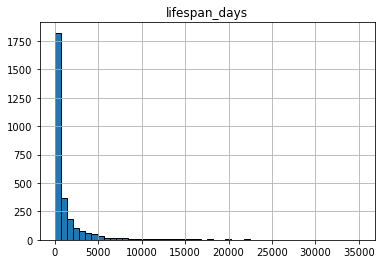

In [124]:
lifespan = get_program_lifespan(df_without_date_outliers)
lifespan['lifespan_class'] = (pd.qcut(
    lifespan.lifespan_days, 5, labels=[0, 1, 2, 3, 4]))
lifespan.hist(column='lifespan_days', bins=50, ec='black')
plt.show()

In [13]:
df_without_date_outliers[[
    'genres', 'publicationChannelNames', 'thematicCorporations',
    'thematicGeographicals', 'thematicPersons', 'thematicThemes',
    'visualCorporations', 'visualGeographicals', 'visualPersons',
    'visualThemes'
]]

genres publicationChannelNames thematicCorporations  \
0                                                                    
1                                                                    
2                                                                    
3                                                                    
4                                                                    
5                                                                    
6                                                                    
7       [Déclaration]                                                
8                                                                    
9       [Déclaration]                                                
10                                                                   
11                                                                   
12            [Récit]           [La Première]                        
13                                                                   
14              [INT]    [Deuxième programme]                        
15      [Commentaire]                                                
16                                                                   
17                                                                   
18        [Interview]                                                
19        [Interview]                                                
20                                                                   
21                                                                   
22      [Déclaration]                                                
23                                                                   
24                                                                   
25            [Récit]           [La Première]                        
26                                                                   
27      [Commentaire]                                                
28                                                                   
29                                                                   
...               ...                     ...                  ...   
372934                          [La Première]                        
372935                          [La Première]                        
372936                          [La Première]                        
372937                          [La Première]                        
372938                          [La Première]                        
372939                          [La Première]                        
372940                          [La Première]                        
372941                          [La Première]                        
372942                          [La Première]                        
372943                          [La Première]                        
372944    [Interview]              [Espace 2]                        
372945                          [La Première]                        
372946                          [La Première]                        
372947                          [La Première]                        
372948                          [La Première]                        
372949                          [La Première]                        
372950                          [La Première]                        
372951                          [La Première]                        
372952                          [La Première]                        
372953                          [La Première]                        
372954                          [La Première]                        
372955                          [La Première]                        
372956                          [La Première]                        
372957                          [La Première]                        
372958                          [La Première]                        
372959                   

In [46]:
df_without_date_outliers[149:151].thematicPersons

149                                                     
150    [Indy, Vincent d', Concerts Lamoureux, Schille...
Name: thematicPersons, dtype: object

In [57]:
df_without_date_outliers.groupby([
    df_without_date_outliers.program,
    df_without_date_outliers.publicationDate.apply(lambda x: x.year)
])[
    'genres', 'publicationChannelNames', 'thematicCorporations','thematicGeographicals',
    'thematicThemes', 'visualCorporations', 'visualGeographicals', 'visualPersons',
    'visualThemes'
].agg(agg_counter)

genres  \
program                publicationDate                                                      
                       1921.0                                                [(Récit, 2)]   
                       1922.0                           [(Commentaire, 2), (Variétés, 2)]   
                       1923.0               [(Documentaire, 2), (Théâtre, 2), (Récit, 1)]   
                       1924.0                                                  [(INT, 2)]   
                       1925.0                       [(Parlé divers, 2), (Commentaire, 2)]   
                       1927.0                                          [(Commentaire, 6)]   
                       1928.0                                          [(Déclaration, 1)]   
                       1929.0           [(Commentaire, 4), (Déclaration, 2), (Intervie...   
                       1930.0             [(Déclaration, 10), (Interview, 4), (Récit, 2)]   
                       1931.0           [(Déclaration, 2), (Commentaire, 2), (Variétés...   
                       1932.0           [(Déclaration, 7), (Interview, 6), (Commentair...   
                       1933.0           [(Déclaration, 8), (Commentaire, 4), (Intervie...   
                       1934.0           [(Déclaration, 6), (Commentaire, 4), (Reportag...   
                       1935.0           [(Déclaration, 19), (Reportage, 5), (Interview...   
                       1936.0           [(Déclaration, 27), (Commentaire, 8), (INT, 7)...   
                       1937.0           [(Déclaration, 17), (Variétés, 15), (Commentai...   
                       1938.0           [(Déclaration, 37), (INT, 23), (Interview, 13)...   
                       1939.0           [(Déclaration, 90), (INT, 82), (Interview, 68)...   
                       1940.0           [(INT, 130), (Commentaire, 82), (Déclaration, ...   
                       1941.0           [(INT, 231), (Commentaire, 128), (Théâtre, 92)...   
                       1942.0           [(INT, 97), (Commentaire, 90), (Théâtre, 77), ...   
                       1943.0           [(INT, 60), (Commentaire, 35), (Déclaration, 2...   
                       1944.0           [(INT, 74), (Commentaire, 61), (Déclaration, 4...   
                       1945.0           [(INT, 218), (Commentaire, 135), (Déclaration,...   
                       1946.0           [(Commentaire, 11), (Déclaration, 10), (INT, 1...   
                       1949.0           [(INT, 113), (Déclaration, 73), (Commentaire, ...   
                       1950.0           [(INT, 130), (Interview, 81), (Déclaration, 64...   
                       1951.0           [(INT, 217), (Indicatif, 135), (Déclaration, 8...   
                       1952.0           [(INT, 225), (Interview, 88), (Déclaration, 76...   
                       1953.0           [(INT, 325), (Interview, 153), (Commentaire, 1...   
...                                                                                   ...   
Zoom avant             2000.0                             [(Informations de service, 41)]   
                       2001.0                             [(Informations de service, 42)]   
                       2002.0                             [(Informations de service, 22)]   
Zèbre                  2004.0                                              [(Sketch, 45)]   
                       2005.0                                              [(Sketch, 40)]   
Zèbres                 2010.0                                                [(Débat, 1)]   
Zéphyr à Zanzibar      2005.0                                            [(Interview, 4)]   
Zéro des Faux          2016.0                                 [(Jeux de courte durée, 5)]   
                       2017.0                                 [(Jeux de courte durée, 5)]   
aXes                   2001.0                       [(Autres émissions d'actualités, 18)]   
faussaires.ch          2001.0                   [(Autres émissions de divertissement

In [55]:
test = df_without_date_outliers[1000:1500].groupby([
    df_without_date_outliers.program,
    df_without_date_outliers.publicationDate.apply(lambda x: x.year)
]).agg({'genres' : agg_counter,
        'publicationChannelNames' : agg_counter,
        'thematicCorporations' : agg_counter,
        'thematicGeographicals' : agg_counter,
        'thematicThemes' : agg_counter,
        'visualCorporations' : agg_counter,
        'visualGeographicals' : agg_counter,
        'visualPersons' : agg_counter,
        'visualThemes' : agg_counter
       })
#.agg(lambda x: Counter([item for sublist in x for item in sublist]).most_common())

TypeError: unhashable type: 'list'

In [54]:
def agg_counter(values):
    return Counter([item for sublist in values for item in sublist]).most_common()

In [193]:
for name,group in test:
    print(name)
    print(group.thematicPersons)
    Counter([item for sublist in group.thematicPersons for item in sublist]).most_common()

('', 1921.0)
93     [Kipling, Rudyard]
94    [Noailles, Anna de]
Name: thematicPersons, dtype: object
('', 1922.0)
91      [Einstein, Albert]
92    [Valentino, Rudolph]
98      [Einstein, Albert]
99    [Valentino, Rudolph]
Name: thematicPersons, dtype: object
('', 1923.0)
95                                                      
96                                                      
101    [Davel, Jean Daniel Abraham, Ramuz, Charles Fe...
102                                                     
103                                                     
Name: thematicPersons, dtype: object
('', 1924.0)
100    [Dreyfus, Alfred, Jeanne d'Arc, Zola, Emile, F...
106    [Dreyfus, Alfred, Jeanne d'Arc, Zola, Emile, F...
Name: thematicPersons, dtype: object
('', 1925.0)
104                     
105    [Stein, Gertrude]
107    [Stein, Gertrude]
108                     
Name: thematicPersons, dtype: object
('', 1927.0)
109       [Carnegie, Andrew]
110    [Conan Doyle, Arthur]
111     [Lindbergh, 

('', 1999.0)
147203                                             
147211                 [Gyatso, Tenzin, dalaï-lama]
147222                        [King, Martin Luther]
147233                                             
147235                                             
147240    [Prix Nobel de la paix 1979, Mère Teresa]
147244                                             
147259                                             
147284                               [Wiesel, Elie]
147291                                             
147297                              [Tutu, Desmond]
147298                                   [Bonny B.]
147302                                             
147306                                             
147312                                     [Gandhi]
147315                                             
147323                       [Radio Suisse Romande]
147324                          [Depardon, Raymond]
147333                                             

('Actualités', 1994.0)
119763                  
119767                  
119799                  
120017    [WALESA, LECH]
121371                  
Name: thematicPersons, dtype: object
('Actualités', 1995.0)
124265    [RABIN, YITZHAK]
125554                    
128342                    
Name: thematicPersons, dtype: object
('Actualités', 1996.0)
138266    
Name: thematicPersons, dtype: object
('Actualités', 1997.0)
139508    
142441    
142521    
143225    
143438    
145190    
146705    
147130    
Name: thematicPersons, dtype: object
('Actualités', 1998.0)
148003                                     
148038                       [MONTI, MARIO]
148278     [CHIRAC, JACQUES, COTTI, FLAVIO]
148932                                     
149208                                     
149231                                     
149264                                     
149293                                     
149315                                     
149345                              

('Babylone', 2013.0)
287698                                                     
287730                                                     
287957                                                     
288209                                                     
288227                                       [Calvin, Jean]
288245                                       [Calvin, Jean]
288360                                                     
288453                                                     
288592                                    [Festival BD Fil]
288675                                              [MUDAC]
288712                                                     
288715                                                     
288720                                                     
288747                                                     
288768                                                     
288922                                                     
289747             

22310    
22349    
22400    
22455    
22456    
22457    
22528    
22595    
23184    
23236    
23290    
23395    
23471    
23476    
23612    
23664    
23666    
23874    
23979    
23981    
Name: thematicPersons, dtype: object
('Carrefour international', 1966.0)
24830    
24911    
25149    
25262    
25502    
25544    
25548    
25662    
25874    
25980    
26087    
Name: thematicPersons, dtype: object
('Carrefour international', 1967.0)
26466    
26551    
26627    
26743    
26873    
26916    
26964    
27016    
27115    
27219    
27375    
27567    
27698    
28062    
28119    
28224    
28317    
28483    
Name: thematicPersons, dtype: object
('Carrefour international', 1968.0)
28647    
28676    
28682    
28774    
28792    
28863    
28912    
29053    
29251    
29461    
29505    
29511    
29512    
29600    
29649    
30033    
30368    
30548    
30643    
30686    
30719    
30841    
Name: thematicPersons, dtype: object
('Carrefour international', 1969.0

105455    
Name: thematicPersons, dtype: object
('Concerts', 1995.0)
124057    
126535    
Name: thematicPersons, dtype: object
('Concerts', 1997.0)
140732    
146124    
Name: thematicPersons, dtype: object
('Concerts', 1998.0)
150397    
150399    
Name: thematicPersons, dtype: object
('Concerts O.C.L.', 1980.0)
55808    
Name: thematicPersons, dtype: object
('Concerts O.C.L.', 1981.0)
58747    
Name: thematicPersons, dtype: object
('Concerts O.C.L.', 1982.0)
61953    
Name: thematicPersons, dtype: object
('Concerts O.C.L.', 1983.0)
63304    
Name: thematicPersons, dtype: object
('Concerts O.C.L.', 1985.0)
72363    [GERECZ, ARPAD]
72538    [GERECZ, ARPAD]
Name: thematicPersons, dtype: object
('Concerts O.C.L.', 1987.0)
79443    
81788    
81873    
Name: thematicPersons, dtype: object
('Concerts O.C.L.', 1988.0)
84804    [LEHEL, GYORGY]
84820    [LEHEL, GYORGY]
85391                   
Name: thematicPersons, dtype: object
('Concerts O.C.L.', 1991.0)
98492     [LOPEZ COBOS, JESUS]
100

('De vive voix', 1967.0)
24153                     [Belles Lettres, Béguin, Pierre]
26958                     [Béguin, Albert, Béguin, Pierre]
27206                                     [Béguin, Pierre]
27308                                     [Béguin, Pierre]
27403    [Motta, Giuseppe, Guisan, Henri, Musy, Jean-Ma...
27639                                     [Béguin, Pierre]
27741                                     [Béguin, Pierre]
27876                     [Belles Lettres, Béguin, Pierre]
Name: thematicPersons, dtype: object
('De vive voix', 1969.0)
31094    [Bibliothèque Nationale Suisse]
31158    [Bibliothèque Nationale Suisse]
31224    [Bibliothèque Nationale Suisse]
31424    [Bibliothèque Nationale Suisse]
31517    [Bibliothèque Nationale Suisse]
31659    [Bibliothèque Nationale Suisse]
31753    [Bibliothèque Nationale Suisse]
31837    [Bibliothèque Nationale Suisse]
32004    [Bibliothèque Nationale Suisse]
32205    [Bibliothèque Nationale Suisse]
32300    [Bibliothèque National

Name: thematicPersons, dtype: object
('Duel', 2000.0)
168800    
169810    
172857    
173894    
173900    
174753    
175670    
176558    
Name: thematicPersons, dtype: object
('Duel', 2001.0)
177388    
178459    
179045    
181419    
182807    
183650    
184482    
Name: thematicPersons, dtype: object
('Duel', 2002.0)
187738    [ZAPPELLI, DANIEL]
189007                      
191844                      
193148                      
194848                      
195668                      
196087                      
Name: thematicPersons, dtype: object
('Duel (Le)', 2017.0)
349203    
355843    
362538    
365435    
366102    
366794    
367557    
367627    
368217    
Name: thematicPersons, dtype: object
('Duel à cache-cache', 1978.0)
51591    
Name: thematicPersons, dtype: object
('Duel à cache-cache', 1979.0)
52876    
52951    
52993    
52995    
53039    
53083    
53129    
53173    
53203    
53244    
53287    
53328    
53334    
53375    
53463    
53482    
53523 

('Espace 700', 1991.0)
96973    
Name: thematicPersons, dtype: object
("Espace de l'Islam", 1987.0)
79593    
79691    
79773    
79859    
79950    
80123    
Name: thematicPersons, dtype: object
('Espace francophone', 1994.0)
117958    
118293    
Name: thematicPersons, dtype: object
('Espace musique', 1993.0)
108461                   [Jordan, Armin, Gall, Hugues, OSR]
108909                                  [Tabachnik, Michel]
109178                                      [Cocteau, Jean]
109363                                                     
110088                                    [Mortier, Gérard]
111372    [Fouchécourt, Jean-Paul, Robin, Jean, Wallez, ...
112029    [Cecatty, René de, Boucourechliev, André, Quil...
112174    [Jouis, François, Harmonic Record, Meunier, Al...
112853                                                     
112918    [Michel, Catherine, Gedda, Nicolai, Ornano, Je...
113080    [Pichon, Jean-Louis, Guérin, Isabelle, Maillot...
113391    [Robin, Jean, Bi

('Fourchette du dimanche', 2012.0)
282047                     
282123                     
282210                     
282301                     
282494                     
282600                     
282752                     
282842    [Girardet, Frédy]
282951                     
Name: thematicPersons, dtype: object
('Franc-parler', 1985.0)
70796    
70975    
71053    
71118    
71128    
71199    
71265    
71331    
71402    
71471    
Name: thematicPersons, dtype: object
('Franc-parler', 1986.0)
73954                         
74035                         
74118                         
74208                         
74301                         
74380                         
74474                         
74563                         
75021    [QUARTIER, ARCHIBALD]
75270                         
75356                         
75441                         
75534                         
75598                         
75711                         
75806                   

('Horizons campagnards', 1966.0)
25098    
Name: thematicPersons, dtype: object
('Horizons féminins', 1965.0)
22305                                 [Desborges, Mlle]
22366    [Aubert, Liliane, Chalut-Bachofen, Etiennette]
22567                                  [Maillart, Ella]
22597                                  [Maillart, Ella]
22635                                  [Maillart, Ella]
22751                                                  
22756                                                  
23239                                                  
23242                                                  
23323                                                  
23480                                                  
Name: thematicPersons, dtype: object
('Horizons féminins', 1966.0)
24895    [Thierry, Solange]
25439                      
25442                      
Name: thematicPersons, dtype: object
('Horizons perdus', 1994.0)
121378    [Petrassi, Goffredo, Vlad, Roman]
Name: thematic

Name: thematicPersons, Length: 271, dtype: object
('Journal de midi', 2012.0)
280109                                                     
280134                                                [UDC]
280146                                                [Max]
280149                                   [Vachoud, Richard]
280154                                             [Migros]
280161                                                     
280224                                                     
280238                                                     
280273                                     [Tinguely, Jean]
280281                                      [Obama, Barack]
280323                        [ASEM - Dialogue Asie-Europe]
280353                                                     
280387                                                     
280389                                               [Unia]
280391                                               [Ruag]
280399                

('Le rêve de vos 20 ans', 1997.0)
138998    
Name: thematicPersons, dtype: object
('Le rêve de vos 20 ans', 1998.0)
148473    
Name: thematicPersons, dtype: object
('Le rêve de vos 20 ans', 1999.0)
160972    
Name: thematicPersons, dtype: object
('Le téléjournal', 1995.0)
123993     
123997     
124000     
124001     
124003     
124004     
124010     
124011     
124014     
124021     
124025     
124026     
124034     
124036     
124038     
124045     
124046     
124049     
124054     
124055     
124058     
124080     
124081     
124102     
124107     
124110     
124111     
124126     
124135     
124136     
         ..
130762     
130780     
130781     
130784     
131009     
131010     
131011     
131035     
131037     
131040     
131051     
131059     
131061     
131083     
131084     
131085     
131106     
131109     
131123     
131124     
131125     
131150     
131151     
131154     
131163     
131164     
131170     
131189     
131190     
131191 

('Messe', 1984.0)
66395    
67346    
67874    
68899    
68904    
Name: thematicPersons, dtype: object
('Messe', 1985.0)
70417    
70418    
71258    
71275    
72613    
72615    
73480    
Name: thematicPersons, dtype: object
('Messe', 1986.0)
73898    
74105    
74669    
76634    
Name: thematicPersons, dtype: object
('Messe', 1987.0)
78804    
79301    
80225    
80884    
Name: thematicPersons, dtype: object
('Messe', 1988.0)
82565    
83782    
84210    
85505    
85910    
Name: thematicPersons, dtype: object
('Messe', 1989.0)
86507    
87712    
88764    
89104    
90549    
Name: thematicPersons, dtype: object
('Messe', 1990.0)
90759    [CORBOZ, MICHEL]
91312                    
92534                    
94624                    
Name: thematicPersons, dtype: object
('Messe', 1991.0)
95810     
96575     
96708     
97306     
98391     
100326    
Name: thematicPersons, dtype: object
('Messe', 1992.0)
103375    
104183    
106962    
108220    
Name: thematicPersons, dtype

Name: thematicPersons, dtype: object
('Noir sur blanc', 1982.0)
59928                                                    
60362                                                    
60476    [GODEL, VAHE, GREGOIRE, HELENE, CLAVEL, BERNARD]
60581                    [DEBLUE, HENRI, JACCARD, ROLAND]
60683               [Z'GRAGGEN, YVETTE, CHESSEX, JACQUES]
60800               [JACQUARD, ALBERT, FRIEDLANDER, SAUL]
60867                                  [SABATIER, ROBERT]
60894                                                    
60984                                                    
60986              [DEONNA, LAURENCE, MEIENBERG, NICOLAS]
61092                                    [GIOVANNI, JOSE]
61292               [FINKIELKRAUT, ALAIN, WINOCK, MICHEL]
61401                                                    
61521                                    [SEMPRUN, JORGE]
61642               [BOUVIER, NICOLAS, GLUCKSMANN, ANDRE]
61843                [STAROBINSKI, JEAN, JACCARD, ROLAND]
61989   

62663     
62678     
62708     
62718     
62728     
62743     
62750     
62786     
62796     
62806     
62818     
62833     
62851     
63669     
63678     
63684     
63700     
63712     
63743     
63754     
63764     
64773     
64784     
64791     
64824     
64837     
64852     
64859     
64932     
64960     
        ..
65068     
65077     
65108     
65120     
65129     
65139     
65181     
65188     
65200     
65214     
65226     
65253     
65265     
65283     
65292     
65310     
65351     
65360     
65371     
65383     
65394     
65421     
65433     
65446     
65457     
65463     
65492     
65505     
65518     
65528     
Name: thematicPersons, Length: 67, dtype: object
('Photos de famille', 2005.0)
216341                                       
216369                                       
216468                                       
216503                                       
216532                                       
216556              

("Quart d'heure vaudois", 1943.0)
3682    
3683    
3692    
3693    
3694    
Name: thematicPersons, dtype: object
("Quart d'heure vaudois", 1957.0)
11799    
Name: thematicPersons, dtype: object
("Quart d'heure vaudois", 1958.0)
13517    
Name: thematicPersons, dtype: object
("Quart d'heure vaudois", 1962.0)
18581    [Marti, Henri]
Name: thematicPersons, dtype: object
("Quart d'heure vaudois", 1966.0)
22227                         
24523                         
24524                         
25872    [RSR, Radio-Lausanne]
Name: thematicPersons, dtype: object
("Quart d'heure vaudois", 1967.0)
26666    
28060    
28274    
Name: thematicPersons, dtype: object
("Quart d'heure vaudois", 1968.0)
29457    
29735    
29737    
30367    
30546    
Name: thematicPersons, dtype: object
("Quart d'heure vaudois", 1969.0)
31125    
32261    
32943    
33093    
Name: thematicPersons, dtype: object
('Quatre sur un piano', 1942.0)
1725    [Chevalier, Maurice, Rollan, Jack]
1730                    

('Republik Kalakuta', 2007.0)
236767    
238439    
240850    
Name: thematicPersons, dtype: object
('Republik Kalakuta', 2008.0)
244908    
246896    
249108    
249147    
Name: thematicPersons, dtype: object
('Republik Kalakuta', 2009.0)
257362                                                   
257364    [Micro Brise le Silence, Bouteflika, Abdelaziz]
258783                                                   
Name: thematicPersons, dtype: object
('Republik Kalakuta', 2010.0)
264694    
Name: thematicPersons, dtype: object
('Repérages', 1990.0)
90696    
Name: thematicPersons, dtype: object
('Repérages', 1991.0)
90672    
Name: thematicPersons, dtype: object
('Retour aux sources', 2008.0)
247381    [Keshavjee, Shafique]
247519         [Ewing, William]
247648         [Naki, Innocent]
247742         [Wenger, Salika]
Name: thematicPersons, dtype: object
('Retour du grand Georges', 1991.0)
95522    [Brassens, Georges]
95524    [Brassens, Georges]
Name: thematicPersons, dtype: object
('Ret

Name: thematicPersons, dtype: object
('Slam Suisse', 2015.0)
300379    
300442    
306696    
306701    
308895    
308958    
310026    
311097    
311162    
Name: thematicPersons, dtype: object
('Smala', 1997.0)
139293                                  [Khaled]
139659                          [Fugain, Michel]
140692                          [Obispo, Pascal]
140880                                          
141053                                  [Popeck]
141312                           [Novembre, Tom]
142377                          [Fersen, Thomas]
142642                               [Enzo Enzo]
143100                          [Evora, Cesaria]
143294    [Centre d'étude la famille (Lausanne)]
143540                         [Roumanoff, Anne]
143850                       [Lemarque, Francis]
143852                                          
144174                       [Légitimus, Pascal]
144187                                          
144316                       [Cavanna, François]
1

('TSR Dialogue', 1996.0)
123958                     
123961                     
123962                     
123963                     
131425                     
131455                     
131531                     
131544                     
131564                     
131592                     
131627                     
131686                     
131687                     
131711                     
131739                     
131754                     
131794                     
131887                     
131913                     
131942                     
131968                     
132038                     
132061                     
132063                     
132096                     
132122                     
132159                     
132221                     
132247                     
132274                     
                ...        
135627                     
135628                     
135629                     
135630                 

Name: thematicPersons, dtype: object
('Télactualité', 1985.0)
71446    
Name: thematicPersons, dtype: object
('Télactualité', 1989.0)
88412    
Name: thematicPersons, dtype: object
('Télescope', 1980.0)
55948    
56316    
Name: thematicPersons, dtype: object
('Télescope', 1981.0)
59012    
59223    
59637    
Name: thematicPersons, dtype: object
('Télescope', 1982.0)
59828    
59911    
60569    
60675    
60841    
61035    
61348    
61567    
62125    
Name: thematicPersons, dtype: object
('Télescope', 1983.0)
62872                                                  
63526                                                  
63768                                                  
63798                                                  
63863                                                  
63864                                                  
64057                                                  
64318                                                  
64445                           

In [186]:
test = df_without_date_outliers[df_without_date_outliers.publicationDateYear == 1921y].thematicPersons.values

In [187]:
Counter([item for sublist in test for item in sublist]).most_common()

[('Kipling, Rudyard', 1), ('Noailles, Anna de', 1)]

## data preparation

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

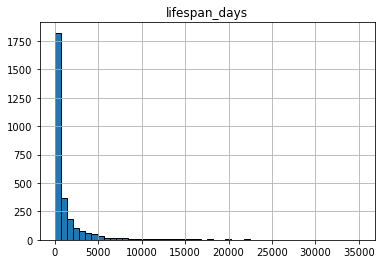

In [14]:
lifespan = get_program_lifespan(df_without_date_outliers)
lifespan['lifespan_class'] = (pd.qcut(
    lifespan.lifespan_days, 2, labels=[0, 1]))
lifespan.hist(column='lifespan_days', bins=50, ec='black')
plt.show()

In [15]:
def generate_data_for_factor(factor):
    factor_per_program = pd.DataFrame()
    factor_per_program[factor] = df_without_date_outliers[factor].apply(
        lambda x: ' '.join(x))
    factor_per_program['program'] = df_without_date_outliers.program
    factors = factor_per_program.groupby(
        factor_per_program.program).agg(lambda x: ' '.join(x))
    evaluate_df = lifespan.merge(factors, left_index=True, right_index=True)
    # drop programs with no name
    evaluate_df = evaluate_df.drop('')
    X = evaluate_df[factor]
    y = evaluate_df.lifespan_class
    return X, y

In [16]:
# classifiers for model selection
count_vect = CountVectorizer(ngram_range=(1, 2), max_df=0.5)
tfidf_transformer = TfidfTransformer()

classifiers = [
    SGDClassifier(alpha=1e-5, random_state=42),
    svm.SVC(),
    RandomForestClassifier(max_depth=5, n_estimators=10)
]

classifiers_name = ['SGDClassifier', 'svc', 'randomforest']

## thematicThemes

In [17]:
X, y = generate_data_for_factor('thematicThemes')

### model selection

In [18]:
X_count = count_vect.fit_transform(X)
X_tfidf = tfidf_transformer.fit_transform(X_count)

In [95]:
for i, classifier in zip(classifiers_name, classifiers):
    scores = cross_val_score(classifier, X_tfidf, y, cv=5)
    print('for {}'.format(i))
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

for SGDClassifier
Accuracy: 0.637 (+/- 0.025)
for svc
Accuracy: 0.501 (+/- 0.001)
for randomforest
Accuracy: 0.654 (+/- 0.041)


### Grid search for random forest

In [99]:
clf = RandomForestClassifier(
    #max_depth=50,
    random_state=42,
    min_samples_leaf=40,
    n_estimators=16,
    max_features='auto')

pipeline = Pipeline([
    ('vect', count_vect),
    ('tfidf', tfidf_transformer),
    ('clf', clf),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    #'clf__max_depth': np.arange(30, 51, 10),
    'clf__n_estimators': np.power(2, np.arange(1, 6, 1)),
    'clf__min_samples_leaf' : np.arange(40,61,5),
}

In [100]:
gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10, cv=3)

In [101]:
gs_clf = gs_clf.fit(X, y)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Paralle

In [19]:
gs_clf.best_score_

NameError: name 'gs_clf' is not defined

In [103]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__min_samples_leaf: 40
clf__n_estimators: 16
vect__max_df: 0.5
vect__ngram_range: (1, 2)


#### with only 2 labels

In [20]:
(X_tfidf.getrow(2))

<1x166098 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [21]:
RFC = RandomForestClassifier( min_samples_leaf=40, n_estimators=16)
RFC.fit(X_tfidf, y)
feat_imp = RFC.feature_importances_

In [34]:
importances = feat_imp
std = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

In [35]:
indices

array([122493,  61949,  39042,  10832, 131960, 104051,  96238, 126951,
         7147,  85574, 140933,   8748, 104040,  21959, 124283,  82587,
       163445,  41442,  24843,  38039], dtype=int64)

Feature ranking:
1. feature 122493 (0.074567)
2. feature 61949 (0.062500)
3. feature 39042 (0.062500)
4. feature 10832 (0.059545)
5. feature 131960 (0.038355)
6. feature 104051 (0.037772)
7. feature 96238 (0.037566)
8. feature 126951 (0.031323)
9. feature 7147 (0.031177)
10. feature 85574 (0.028217)
11. feature 140933 (0.024414)
12. feature 8748 (0.024145)
13. feature 104040 (0.021919)
14. feature 21959 (0.021275)
15. feature 124283 (0.019440)
16. feature 82587 (0.019201)
17. feature 163445 (0.019183)
18. feature 41442 (0.014295)
19. feature 24843 (0.011348)
20. feature 38039 (0.010639)


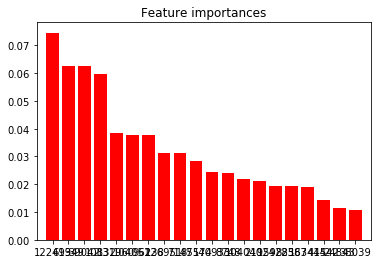

In [36]:
# Print the feature ranking
range_ = range(len(indices))

print("Feature ranking:")

for f in range_:
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(
    range_,
    importances[indices],
    color="r",
    #yerr=std[indices],
    align="center")
plt.xticks(range_, indices)
plt.xlim([-1, len(indices)])
plt.show()

## Visual theme

## Thematic theme

## Location theme